# Linear Regression model for proportional muscular fatigue estimation

## Importing libraries and defining global variables

In [ ]:
from google.colab import drive
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import joblib

In [ ]:
EXP_TYPE = 'MULTIPLE' # Options: 'SINGLE', 'MULTIPLE'
FEATURE = 'MAV' # Options: 'RAW', 'MAV', 'RMS', 'MNF'
USER = 'H001B0101' # Options: 'H001B0101', 'H002B0101', 'H003B0101', 'H004B0101', 'H022B0101', 'H023B0101', 'H024B0101', 'H031B0101', 'H032B0101'
LEVEL_TYPE = 'FLOAT' #Options: 'FLOAT', 'INT'

## Data Loading

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
if FEATURE == 'RAW':
  run2 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_2.csv"
  run3 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_3.csv"
  run4 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_4.csv"

elif FEATURE == 'MAV':
  run2 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_2_mav.csv"
  run3 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_3_mav.csv"
  run4 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_4_mav.csv"

elif FEATURE == 'RMS':
  run2 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_2_rms.csv"
  run3 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_3_rms.csv"
  run4 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_4_rms.csv"

elif FEATURE == 'MNF':
  run2 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_2_mnf.csv"
  run3 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_3_mnf.csv"
  run4 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_4_mnf.csv"

In [ ]:
if EXP_TYPE == 'SINGLE':
  hdemg_data = pd.read_csv(run2) # Load data containing HD-EMG signals

  if (USER == 'H001B0101' or USER == 'H002B0101' or USER == 'H003B0101') and FEATURE == 'MAV':
    hdemg_data = hdemg_data.iloc[:-1000] # Remove the last 1000 rows as there is an undesired peak

  # Generate the fatigue levels with linear assumption
  if LEVEL_TYPE == 'FLOAT':
    fatigue_level_synthetic = np.linspace(0, 100, num=hdemg_data.shape[0])
  elif LEVEL_TYPE == 'INT':
    fatigue_level_synthetic = np.linspace(0, 100, num=hdemg_data.shape[0]).astype(int)

# ------------------------------------------------------------------------------

elif EXP_TYPE == 'MULTIPLE':
  # Load data containing HD-EMG signals
  hdemg_data_2 = pd.read_csv(run2)
  hdemg_data_3 = pd.read_csv(run3)
  hdemg_data_4 = pd.read_csv(run4)

  if (USER == 'H001B0101' or USER == 'H002B0101' or USER == 'H003B0101') and FEATURE == 'MAV':
    # Remove the last 1000 rows as there is an undesired peak
    hdemg_data_2 = hdemg_data_2.iloc[:-1000]
    hdemg_data_3 = hdemg_data_3.iloc[:-1000]
    hdemg_data_4 = hdemg_data_4.iloc[:-1000]

  # Generate the fatigue levels with linear assumption
  if LEVEL_TYPE == 'FLOAT':
    fatigue_level_2 = np.linspace(0, 100, num=hdemg_data_2.shape[0])
    fatigue_level_3 = np.linspace(0, 100, num=hdemg_data_3.shape[0])
    fatigue_level_4 = np.linspace(0, 100, num=hdemg_data_4.shape[0])
  elif LEVEL_TYPE == 'INT':
    fatigue_level_2 = np.linspace(0, 100, num=hdemg_data_2.shape[0]).astype(int)
    fatigue_level_3 = np.linspace(0, 100, num=hdemg_data_3.shape[0]).astype(int)
    fatigue_level_4 = np.linspace(0, 100, num=hdemg_data_4.shape[0]).astype(int)

  # Add columns names, as the original dataframe doesn't have any
  new_columns = [f"Channel {i}" for i in range(1, 65)]
  hdemg_data_2.columns = new_columns
  hdemg_data_3.columns = new_columns
  hdemg_data_4.columns = new_columns

  # Concatenate experiment runs 2 and 3, as it's the train data
  hdemg_data = pd.concat([hdemg_data_2, hdemg_data_3], axis=0)
  fatigue_level_2_df = pd.DataFrame(fatigue_level_2,columns=["Fatigue level"])
  fatigue_level_3_df = pd.DataFrame(fatigue_level_3,columns=["Fatigue level"])
  fatigue_level_synthetic = pd.concat([fatigue_level_2_df, fatigue_level_3_df], axis=0)


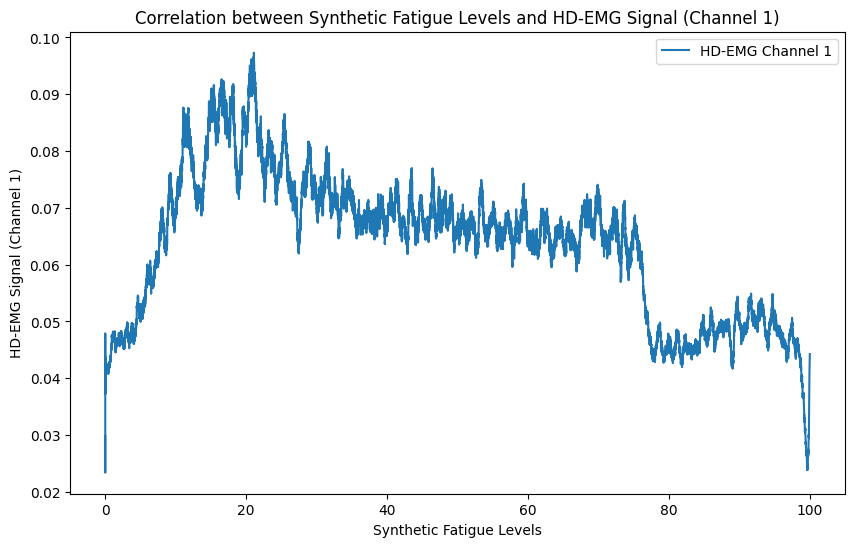

In [ ]:
if EXP_TYPE == 'SINGLE':
  # Define the number of samples and channels
  samples = hdemg_data.shape[0]
  channels = hdemg_data.shape[1]

  # Create synthetic labels for fatigue levels
  yn = np.linspace(0, 100, num=samples)

  # Show HD-EMG signal and fatigue level correlation for a single channal
  plt.figure(figsize=(10, 6))
  plt.plot(fatigue_level_synthetic, hdemg_data.iloc[:, 0], label='HD-EMG Channel 1')
  plt.xlabel('Synthetic Fatigue Levels')
  plt.ylabel('HD-EMG Signal (Channel 1)')
  plt.title('Correlation between Synthetic Fatigue Levels and HD-EMG Signal (Channel 1)')
  plt.legend()
  plt.show()

## Model definition, training and evaluation

In [ ]:
if EXP_TYPE == 'SINGLE':
  # Split the data into training and testing sets with 80-20 ratio
  X_train, X_test, y_train, y_test = train_test_split(hdemg_data, fatigue_level_synthetic, test_size=0.2, random_state=42)

elif EXP_TYPE == 'MULTIPLE':
  X_train = hdemg_data
  y_train = fatigue_level_synthetic
  X_test = hdemg_data_4
  y_test = fatigue_level_4

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)
if EXP_TYPE == 'MULTIPLE':
  y_pred = y_pred.flatten()

# Evaluate the model's performance
score = model.score(X_test, y_test)
correlation_coefficient, p_value = pearsonr(y_pred, y_test)

# Print the metric's results
print("R^2 Score:", score)
print("Pearson correlation coefficient:", correlation_coefficient)


R^2 Score: 0.8860251172913549
Pearson correlation coefficient: 0.9412901781561369


In [ ]:
#@title K-fold Cross Validation intra-subject (2 experiment runs for training and 1 for testing)

# Define linear regression model
model = LinearRegression()

# Define k-fold cross validation object
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Initialize list to store cross-validation scores
r2_scores = []
pcorr_values = []

# Perform cross-validation
for train_index, test_index in kf.split([2, 3, 4]):
    print("train: ", train_index+2)
    print("test: ", test_index+2)
    # Select experiments for training and testing
    train_exp = [hdemg_data_2, hdemg_data_3, hdemg_data_4][train_index[0]], [hdemg_data_2, hdemg_data_3, hdemg_data_4][train_index[1]]
    X_test = [hdemg_data_2, hdemg_data_3, hdemg_data_4][test_index[0]]
    train_fatigue = [fatigue_level_2, fatigue_level_3, fatigue_level_4][train_index[0]], [fatigue_level_2, fatigue_level_3, fatigue_level_4][train_index[1]]
    y_test = [fatigue_level_2, fatigue_level_3, fatigue_level_4][test_index[0]]

    # Combine data for training
    X_train = pd.concat(train_exp, axis=0)
    y_train = np.concatenate(train_fatigue)

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model on the test set
    score = model.score(X_test, y_test)
    r2_scores.append(score)
    predicts = model.predict(X_test)
    correlation_coefficient, p_value = pearsonr(predicts, y_test)
    pcorr_values.append(correlation_coefficient)

# Print the metric's results
print("R^2 scores:", r2_scores)
print("Average R^2 score:", np.mean(r2_scores))
print("Pearson Correlation Coefficient values:", pcorr_values)
print("Average Pearson Correlation Coefficient value:", np.mean(pcorr_values))


train:  [3 4]
test:  [2]
train:  [2 4]
test:  [3]
train:  [2 3]
test:  [4]
R^2 scores: [-0.007910947751843533, 0.5428408559481646, 0.2869970529865623]
Average R^2 score: 0.2739756537276278
Pearson Correlation Coefficient values: [0.48308578261661994, 0.8407183992431486, 0.6853715285239914]
Average Pearson Correlation Coefficient value: 0.6697252367945866


In [ ]:
#@title K-fold Cross Validation intra-subject (All experiment runs combined)

# Concatenate the data and fatigue levels
hdemg_data_combined = pd.concat([hdemg_data_2, hdemg_data_3, hdemg_data_4], axis=0)
fatigue_level_combined = np.concatenate([fatigue_level_2, fatigue_level_3, fatigue_level_4])

# Define linear regression model
model = LinearRegression()

# Define k-fold cross validation object
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Initialize list to store cross-validation scores
r2_scores = []
pcorr_values = []

fold = 0
# Perform cross-validation
for train_index, test_index in kf.split(hdemg_data_combined):
    fold += 1
    print(f"Fold: {fold}")
    # Split data into training and testing sets
    X_train, X_test = hdemg_data_combined.iloc[train_index], hdemg_data_combined.iloc[test_index]
    y_train, y_test = fatigue_level_combined[train_index], fatigue_level_combined[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model on the test set
    score = model.score(X_test, y_test)
    r2_scores.append(score)
    predicts = model.predict(X_test)
    correlation_coefficient, p_value = pearsonr(predicts, y_test)
    pcorr_values.append(correlation_coefficient)

# Print the metric's results
print("R^2 scores:", r2_scores)
print("Average R^2 score:", np.mean(r2_scores))
print("Pearson Correlation Coefficient values:", pcorr_values)
print("Average Pearson Correlation Coefficient value:", np.mean(pcorr_values))

Fold: 1
Fold: 2
Fold: 3
R^2 scores: [0.7401097087465394, 0.7389223307780768, 0.7387895500473893]
Average R^2 score: 0.7392738631906685
Pearson Correlation Coefficient values: [0.8602963246598911, 0.8596077318903419, 0.859530226692218]
Average Pearson Correlation Coefficient value: 0.8598114277474836


In [ ]:
#@title K-fold Cross Validation with all the subjects

# List with all the subject's names
file_names = [
    "H001B0101", "H002B0101", "H003B0101", "H004B0101", "H022B0101", "H023B0101",
    "H024B0101", "H031B0101", "H032B0101"
]

# DataFrame to store all the data
hdemg_data_combined = pd.DataFrame()
# Array to store the fatigue levels
fatigue_level_combined = np.array([])

for file_name in file_names:
    print(f"Cargando usuario {file_name}")
    # Build file path for every subject
    file_path_base = "/content/drive/MyDrive/HDEMG/"
    new_columns = [f"Channel {i}" for i in range(1, 65)]

    # Read and process data for experiment run 2 -------------------------------
    file_path = f"{file_path_base}/{file_name}/emg_experiment_2_mav.csv"
    hdemg_data_2 = pd.read_csv(file_path)
    if file_name == 'H001B0101' or file_name == 'H002B0101' or file_name == 'H003B0101':
      hdemg_data_2 = hdemg_data_2.iloc[:-1000] # Remove the last 1000 rows as there is an undesired peak
    hdemg_data_2.columns = new_columns
    fatigue_level_2 = np.linspace(0, 100, num=hdemg_data_2.shape[0])

    # Read and process data for experiment run 3 -------------------------------
    file_path = f"{file_path_base}/{file_name}/emg_experiment_3_mav.csv"
    hdemg_data_3 = pd.read_csv(file_path)
    if file_name == 'H001B0101' or file_name == 'H002B0101' or file_name == 'H003B0101':
      hdemg_data_3 = hdemg_data_3.iloc[:-1000] # Remove the last 1000 rows as there is an undesired peak
    hdemg_data_3.columns = new_columns
    fatigue_level_3 = np.linspace(0, 100, num=hdemg_data_3.shape[0])

    # Read and process data for experiment run 4 -------------------------------
    file_path = f"{file_path_base}/{file_name}/emg_experiment_4_mav.csv"
    hdemg_data_4 = pd.read_csv(file_path)
    if file_name == 'H001B0101' or file_name == 'H002B0101' or file_name == 'H003B0101':
      hdemg_data_4 = hdemg_data_4.iloc[:-1000] # Remove the last 1000 rows as there is an undesired peak
    hdemg_data_4.columns = new_columns
    fatigue_level_4 = np.linspace(0, 100, num=hdemg_data_4.shape[0])

    # Concatenate data from all experiment runs for the current subject
    hdemg_data_subject_combined = pd.concat([hdemg_data_2, hdemg_data_3, hdemg_data_4], axis=0)
    fatigue_level_subject_combined = np.concatenate([fatigue_level_2, fatigue_level_3, fatigue_level_4])

    # Concatenate data and fatigue levels for all subjects
    hdemg_data_combined = pd.concat([hdemg_data_combined, hdemg_data_subject_combined], axis=0)
    fatigue_level_combined = np.concatenate([fatigue_level_combined, fatigue_level_subject_combined])


# Define linear regression model
model = LinearRegression()

# Define k-fold cross-validation object
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Initialize list to store cross-validation scores
r2_scores = []
pcorr_values = []

# Perform cross-validation
for train_index, test_index in kf.split(hdemg_data_combined):
    # Split data into training and testing sets
    X_train, X_test = hdemg_data_combined.iloc[train_index], hdemg_data_combined.iloc[test_index]
    y_train, y_test = fatigue_level_combined[train_index], fatigue_level_combined[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model on the test set
    score = model.score(X_test, y_test)
    r2_scores.append(score)
    predicts = model.predict(X_test)
    correlation_coefficient, p_value = pearsonr(predicts, y_test)
    pcorr_values.append(correlation_coefficient)

# Print cross-validation scores and correlation coefficients
print("Cross-validation scores:", r2_scores)
print("Average cross-validation score:", np.mean(r2_scores))
print("Correlation coefficients:", pcorr_values)
print("Average correlation coefficient:", np.mean(pcorr_values))

Cargando usuario H001B0101
Cargando usuario H002B0101
Cargando usuario H003B0101
Cargando usuario H004B0101
Cargando usuario H022B0101
Cargando usuario H023B0101
Cargando usuario H024B0101
Cargando usuario H031B0101
Cargando usuario H032B0101
Cross-validation scores: [0.3304318735573728, 0.3304304738082159, 0.33217841134234094]
Average cross-validation score: 0.33101358623597654
Correlation coefficients: [0.574833233271727, 0.5748315641676133, 0.5763523105272144]
Average correlation coefficient: 0.5753390359888516


## Plotting results and saving the model

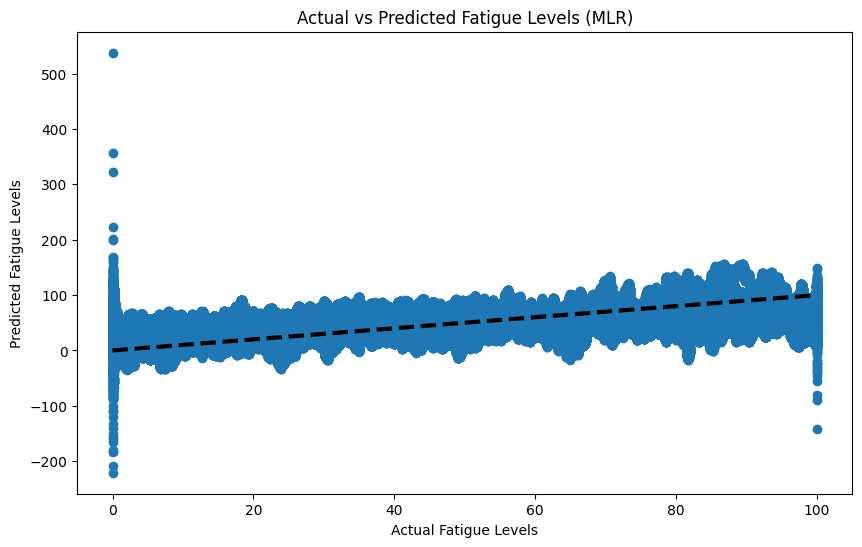

In [ ]:
# Make predictions on the testing set
y_pred = model.predict(X_test)
if EXP_TYPE == 'MULTIPLE':
  y_pred = y_pred.flatten()

# Plotting predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual Fatigue Levels')
plt.ylabel('Predicted Fatigue Levels')
plt.title('Actual vs Predicted Fatigue Levels (MLR)')
plt.show()

In [ ]:
# Save the trained model
joblib.dump(model, 'linear_regression_model.pkl')

['linear_regression_model.pkl']